# Project Objective
Create two models (Monte-Carlo and Neural-Network) to compute the price of an Asian Arithmetic call option and compare the models.

## Import modules

In [46]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import scipy.stats as sp
from tqdm import tqdm
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

print(tf.__version__)

2.10.0


# 1- Monte-Carlo algorithm

## 1.1- Functions definitions

In [47]:
def MonteCarlo_option(n_path, S0, n_step, T, r, mu, sigma, K):
    """
    Full Monte Carlo engine for pricing an Asian call option.

    Parameters:
    - n_path: int, number of paths to simulate
    - S0: float, initial stock price
    - n_step: int, number of steps in each path
    - T: float, time to maturity
    - r: float, risk-free interest rate
    - mu: float, drift term (can differ from r)
    - sigma: float, volatility
    - K: float, strike price

    Returns:
    - float: estimated discounted Asian option price
    """

    #Make sure variables are in the correct type.
    n_step = int(n_step)
    n_path = int(n_path)
    #Find the time step.
    time_step = T / n_step
    #Create an empty DataFrame to store the paths to be generated.
    paths = np.ones((n_step + 1, n_path))
    #Initiate the paths starting point with the initial stock price.
    paths[0] = S0

    #Over the number of steps, generate the next price for each path. Assume it follows a log normal process.
    for i in range(1, n_step + 1):
        random_values = np.random.normal(0, 1, size=n_path)
        paths[i] = paths[i - 1] * np.exp((mu - 0.5 * sigma ** 2) * time_step + sigma * np.sqrt(time_step) * random_values)

    #Compute the expected payoff for the Asian call option.
    payoff = np.maximum(np.mean(paths, axis=0) - K, 0)
    #Discount the expected payoff to retrieve the price.
    return np.exp(-r * T) * np.mean(payoff)


## 1.2- Data generation for Monte-Carlo Simulation

In [48]:
# --- Parameter Grids for Scenario Generation ---
# Define parameter ranges for simulation (grid search style)
T = np.round(np.linspace(0.5, 3, 6),2) # Time to maturity: 6 values from 0.5 to 3 years
r = np.linspace(0, 0.06, 3) # Risk-free rate: 3 values from 0% to 6%
mu = np.linspace(0, 0.3, 6) # Drift: 6 values from 0 to 30%
sigma = np.linspace(0.05, 0.4, 6) # Volatility: 6 values from 5% to 40%
S0 = np.linspace(50, 150, 10) # Initial stock price: 10 values from 50 to 150
K = np.linspace(0.7, 1.3, 7) # Strike as a % of S0: 7 values from 70% to 130%

# Convert maturities to number of time steps (assuming 264 trading days per year)
n_step = T*264

# Simulation parameters
n_simulations = int(10**4) # Number of Monte Carlo paths
n_scenarios = 6*3*6*6*10*7 # Total number of parameter combinations = 45360


# Create a dataframe to store all parameters combinations and computation results.
Results = pd.DataFrame(np.zeros([n_scenarios, 8]), columns=['T', 'n_step', 'r', 'mu', 'sigma', 'S0', 'K','Price'])


# --- Fill the DataFrame with All Parameter Combinations ---
count = 0
for i_T in range(len(T)) :
    for i_r in range(len(r)) :
        for i_mu in range(len(mu)) :
            for i_sigma in range(len(sigma)) :
                for i_S0 in range(len(S0)) :
                    for i_K in range(len(K)) :
                        Results['T'].iloc[count] = T[i_T]
                        Results['n_step'].iloc[count] = int(n_step[i_T])
                        Results['r'].iloc[count] = r[i_r]
                        Results['mu'].iloc[count] = mu[i_mu]
                        Results['sigma'].iloc[count] = sigma[i_sigma]
                        Results['S0'].iloc[count] = S0[i_S0]
                        Results['K'].iloc[count] = K[i_K] * S0[i_S0]

                        #Print progress
                        print(round(count/n_scenarios, 2)*100,'%')
                        count+=1

0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 %
0.0 

## 1.3- Asian arithmetic Option pricing using Monte-Carlo

In [ ]:
# --------------------------------------------
# Price the Options Using Monte Carlo Method
# Save Partial Checkpoints Every 10% of Dataset
# --------------------------------------------

n = len(Results['K'])# Total number of scenarios

for i in range(10) :# Split into 10 batches to avoid memory overload
    print(i)
     # Slice batch i from the full dataset
    calculation = Results[int(n/10)*i:int(n/10)*(i+1)-1]

    # Compute prices using Monte Carlo, with tqdm progress bar
    Prices = map(lambda x2,x3,x4,x5,x6,x7,x8 : MonteCarlo_option(n_simulations,x2,x3,x4,x5,x6,x7,x8), calculation['S0'], calculation['n_step'], calculation['T'], calculation['r'], calculation['mu'],calculation['sigma'], calculation['K'])
    
    # Convert results to list while tracking progress
    test = list(tqdm(Prices))
    
    # Store the results in the dataframe
    calculation['Price'] = test

    # Save a full checkpoint file (including n_step)
    calculation.to_csv("./checkpoint_{}.csv".format(i))
    
    # Save a reduced version (without n_step) for use in ML models
    data = calculation.copy()
    data.pop('n_step')
    data.to_csv("./data_checkpoint_{}.csv".format(i))

0


4535it [03:15, 23.24it/s]
/var/folders/lr/7kzpljcn0zl52pt8zpscgfj40000gn/T/ipykernel_53034/2318480866.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calculation['Price'] = test


1


4535it [04:16, 17.69it/s]


2


4535it [06:21, 11.90it/s]


3


4535it [08:22,  9.03it/s]


4


4535it [09:41,  7.80it/s]


5


4535it [12:25,  6.08it/s]


6


4535it [13:20,  5.67it/s]


7


4535it [15:23,  4.91it/s]


8


4535it [17:24,  4.34it/s]


9


4535it [18:26,  4.10it/s]


# 2- NEURAL NETWORK

## 2.1- Prepare datasets

### Import data
We use the data generated above. However we do not use the Monte-Carlo price as a benchmark.

In [50]:
data_NN = pd.read_csv('data_checkpoint_0.csv', index_col=0)
for i in range(9) :
    current = pd.read_csv('data_checkpoint_{}.csv'.format(i+1), index_col=0)
    data_NN = pd.concat([data_NN, current])
#Get rid of the Monte-Carlo price, it is not interesting for the Neural network training.
data_NN.pop('Price')

data_NN.describe()

,T,r,mu,sigma,S0,K
count,45350.000000,45350.000000,45350.000000,45350.000000,45350.000000,45350.000000
mean,1.749978,0.029999,0.149993,0.224992,99.998775,99.991792
std,0.853924,0.024495,0.102473,0.119552,31.914589,38.196067
min,0.500000,0.000000,0.000000,0.050000,50.000000,35.000000
25%,1.000000,0.000000,0.060000,0.120000,72.222222,67.222222
50%,1.750000,0.030000,0.120000,0.190000,94.444444,94.444444
75%,2.500000,0.060000,0.240000,0.330000,127.777778,126.666667
max,3.000000,0.060000,0.300000,0.400000,150.000000,195.000000


### Compute the prices benchmark using the geometric asian option formula.
The Geometric Asian option don't have the same payoff, but the similarity and the existence of a closed-form solution make it a great candidate to evaluate and train our model.

In [51]:
#Create a copy of the dataframe to avoid adding columns to our data.
pricing_data = data_NN.copy()
pricing_data['sigma_G'] = pricing_data['sigma']/np.sqrt(3)
pricing_data['b'] = 1/2 * (pricing_data['r'] - 1/2 * pricing_data['sigma_G']**2)
pricing_data['d1'] = (np.log(pricing_data['S0']/pricing_data['K']) + (pricing_data['b'] + 1/2 * pricing_data['sigma_G']**2) * pricing_data['T']) / (pricing_data['sigma_G'] * pricing_data['T'])
pricing_data['d2'] = pricing_data['d1'] - pricing_data['sigma_G'] * np.sqrt(pricing_data['T'])

#Compute the Geometric Asian call option price.
pricing_data['Th_Price'] = pricing_data['S0'] * np.exp((pricing_data['b']-pricing_data['r'])*pricing_data['T']) * sp.norm.cdf(pricing_data['d1']) - pricing_data['K'] * np.exp(- pricing_data['r'] * pricing_data['T']) * sp.norm.cdf(pricing_data['d2'])

#Create a new column in the original dataset containing the benchmark for the Arithmetic Asian call option price.
data_NN['Th_price'] = pricing_data['Th_Price']

data_NN.head()

,T,r,mu,sigma,S0,K,Th_price
0,0.5,0.0,0.0,0.05,50.0,35.0,1.499479e+01
1,0.5,0.0,0.0,0.05,50.0,40.0,9.994792e+00
2,0.5,0.0,0.0,0.05,50.0,45.0,4.994792e+00
3,0.5,0.0,0.0,0.05,50.0,50.0,4.045408e-01
4,0.5,0.0,0.0,0.05,50.0,55.0,4.381206e-11


### Split training from validation data.

In [52]:
#Split sets
train_set, test_set = train_test_split(data_NN, test_size = 0.3)

#Separate label from features
train_features = train_set.copy()
test_features = test_set.copy()

train_labels = train_features.pop('Th_price')
test_labels = test_features.pop('Th_price')

### Function to study the model performances

In [53]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Price]')
  plt.legend()
  plt.grid(True)

## 2.2- Construction and training of the network

In [54]:
#Add a normalisation layer in the network
#Adapt the normalization layer to our data
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
#print(normalizer.mean.numpy())

#Create the model
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(124, activation='relu'),
    layers.Dense(units=1)
])

# Train the model
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

#%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

### Save the model

In [55]:
model_name = 'reg_10'
linear_model.save(model_name)

# Save training history as CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv(model_name+'/training_history.csv', index=False)

INFO:tensorflow:Assets written to: reg_10/assets


## 2.3- Model evaluation

### History check and overfitting

{'linear_model': 0.04390532150864601}


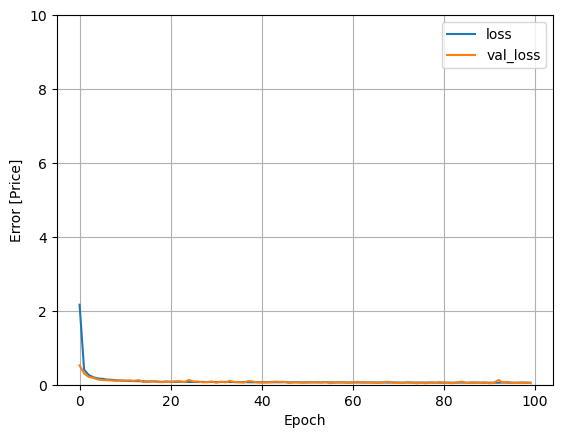

In [56]:
test_results={}
plot_loss(history)
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)
print(test_results)

### Accuracy

426/426 [==============================] - 0s 428us/step


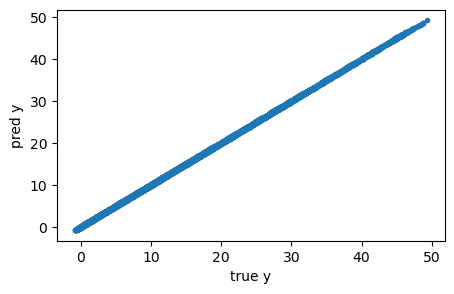

In [57]:
loaded_model = load_model("reg_10")
y_pred = loaded_model.predict(test_features)

plt.figure(figsize = (5,3))
plt.plot(test_labels, y_pred, '.')
plt.xlabel('true y')
plt.ylabel('pred y')
plt.show()

# 3 Compare the Neural Network and Monte Carlo (speed and accuracy).
For the model comparison, we use the validaton set.

## Dataset

In [58]:
comparison_data = test_features.copy()
comparison_data.describe()
length = comparison_data.shape[0]

## 3.1- Speed Comparison

### Monte-Carlo speed evaluation

In [61]:
# Set parameters
n_simulation = int(10**4)

Prices_MC = []
Times_MC = [0]
comparison_data['n_step'] = comparison_data['T'] * 264
# Compute prices with Monte-Carlo using a 'for' loop so we can monitor the time measurement. 
# Note that this method is slower than the map/lambda method used above.
for x2, x3, x4, x5, x6, x7, x8 in tqdm(zip(
    comparison_data['S0'],
    comparison_data['n_step'],
    comparison_data['T'],
    comparison_data['r'],
    comparison_data['mu'],
    comparison_data['sigma'],
    comparison_data['K']
), total=len(comparison_data)):
    start = time.time()
    price = MonteCarlo_option(n_simulations, x2, x3, x4, x5, x6, x7, x8)
    end = time.time()

    Prices_MC.append(price)
    Times_MC.append(Times_MC[-1] + end - start)

100%|██████████| 13605/13605 [32:23<00:00,  7.00it/s]


In [65]:
comparison_data.head()

,T,r,mu,sigma,S0,K,n_step
23592,2.0,0.00,0.12,0.12,50.000000,45.000000,528.0
39874,3.0,0.00,0.24,0.40,116.666667,105.000000,792.0
22324,1.5,0.06,0.30,0.05,150.000000,120.000000,396.0
36299,2.5,0.06,0.12,0.19,105.555556,116.111111,660.0
30425,2.5,0.00,0.00,0.19,116.666667,116.666667,660.0


### Neural-Network speed evaluatiuon

In [66]:
#Import saved NN model
loaded_model = load_model("reg_10")

#Measure time for one prediction
start = time.time()
y_pred = loaded_model.predict(comparison_data.drop('n_step', axis = 1)[:1])
end = time.time()

Time_NN1 = end - start

#Measure time for predicting the whole set
start = time.time()
Prices_NN = loaded_model.predict(comparison_data.drop('n_step', axis = 1))
end = time.time()

Time_NN = end - start
print(Time_NN1, Time_NN)

426/426 [==============================] - 0s 700us/step
0.5278520584106445 0.544468879699707


### Plot the result

0.14247940819561


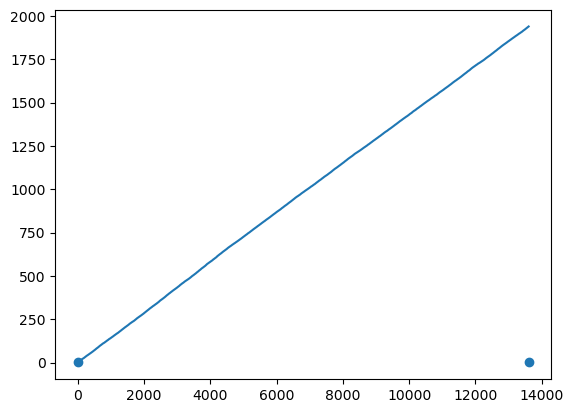

In [71]:
plt.figure()
plt.plot(np.arange(0, length), Times_MC[1:])
plt.scatter([1, length], [Time_NN1, Time_NN])
print(Times_MC[-1]/len(Times_MC))
plt.show()

It takes approximatly the same time to the Neural-Network to make one or 130000 predictions, approximatly 0.52 seconds. For the Monte-Carlo algorithm, it takes on average 0.14 per predictions. Hence, for one or two predictions, the Monte-Carlo Algorithm is faster. However, for more the Neural-Network is fatser.

## 3.2- Accuracy comparison

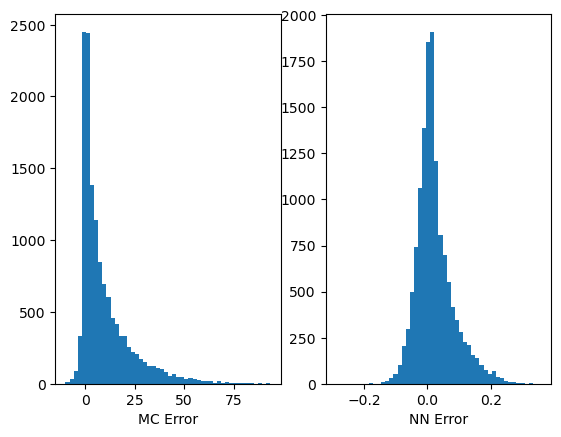

MC Average Error = 9.45481050682269
NN Average Error = 0.022667273212704977
MC Error std = 13.016268554525357
NN Error std = 0.058851148205972564


In [73]:
# Add the Monte-Carlo and the Neural Network prices to the originial dataset.
comparison_data['Prices_MC'] = Prices_MC
comparison_data['Prices_NN'] = Prices_NN
comparison_data['Th_Prices'] = test_labels

#Compute the errors
comparison_data['Error_MC'] = comparison_data['Prices_MC'] - comparison_data['Th_Prices']
comparison_data['Error_NN'] = comparison_data['Prices_NN'] - comparison_data['Th_Prices']

#Study the distribution of errors
plt.figure()
plt.subplot(1,2,1)
plt.hist(comparison_data['Error_MC'], bins = 50)
plt.xlabel('MC Error')
plt.subplot(1,2,2)
plt.hist(comparison_data['Error_NN'], bins = 50)
plt.xlabel('NN Error')
plt.show()

print('MC Average Error = {}'.format(np.mean(comparison_data['Error_MC'])))
print('NN Average Error = {}'.format(np.mean(comparison_data['Error_NN'])))

print('MC Error std = {}'.format(np.std(comparison_data['Error_MC'])))
print('NN Error std = {}'.format(np.std(comparison_data['Error_NN'])))

According to every accuracy criteria, the Neural-Network model is more accurate than the Monte-Carlo algorithm.